# Fitting of Molecular Electron Densities. 

This example will showcase how to fit a linear combination of Gaussian functions (e.g. $e^{-\alpha (x^2 + y^2 + z^2) }$ or $(x^2 + y^2 + z^2) e^{-\alpha (x^2 + y^2 + z^2) }$) to a three-dimensional probability distribution $\rho(x, y, z) : \mathbb{R}^3 \rightarrow \mathbb{R}.$

In particular, $\rho$ will be the electron density function of water ($H_2O$) obtained from using the python package chemtools on a Gaussian format checkpoint (fchk) file.

This algorithm will optimize the Kullback-Leibler formula $K(\rho, \tilde{\rho})$ to find the best Gaussian density model $\tilde{\rho}(x, y, z)$ that approximates $\rho$.
In other words,

$$\arg\min_{\tilde{\rho}}  K(\tilde{\rho}, \rho) = \arg\min_{\tilde{\rho}}  \int_{-\infty}^{\infty} \int_{-\infty}^{\infty} \int_{-\infty}^{\infty} \rho(x, y, z) \log\bigg(\frac{\rho(x, y, z)}{\tilde{\rho}(x, y, z)} \bigg) dx dy dz $$

### Model
The Gaussian density model of $N$ atoms is built from linear combination of S-type and P-type orbitals centered at each 
nucleus $(x_i, y_i, z_i)$ of that atom. In other words,

$$\tilde{\rho}(r) = \sum_{j=1}^{N} \sum_i c_{ij} \bigg(\frac{\alpha_{ij}}{\pi}\bigg)^{\frac{3}{2}} e^{-\alpha_{ij} r_i^2} + \sum_{j=1}^N \sum_k d_{ik} \bigg(\frac{3\pi^{1.5}}{2 \beta_{ik}^{2.5}}\bigg)r_i^2 e^{-\beta_{ik} r_i^2},$$

where $r_i$ is the radius from the point to the nucleus/atomic center (ie $r_i = \sqrt{(x - x_i)^2 + (y - y_i)^2 + (z - z_i)^2}$) and the coefficients
sum to the number of electrons $N_{elec}$. In other words, $ \sum c_i + \sum d_i = N_{elec}$. 

## 1. Specify the Grid.

The first step is to specify a grid on which the probability distribution $\rho$ will be defined on. Here, a uniform cubic grid will be used from $[-4.5, 4.5]^3$ with a step-size of $0.05$.

In [6]:
import numpy as np
import matplotlib

from bfit.grid import CubicGrid

grid = CubicGrid(-4.5, 4.5, 0.05)

## 2. Obtain the Molecular Density.

Now, having the grid, we will need to put values of $\rho(x, y, z)$ on a grid. This will be done using Chemtools. The format checkpoint file "h20_ub3lyp_6311g.fchk" is located "./bfit/data/examples/".

In [7]:
import chemtools
from chemtools.wrappers.molecule import Molecule

mol = Molecule.from_file(r"../bfit/data/examples/h2o_ub3lyp_6311g.fchk")
density = mol.compute_density(grid.points)
print("The Coordinates of water are: ", mol.coordinates)
print("The integration is: ", grid.integrate(density))

Initialized: <horton.gbasis.cext.GOBasis object at 0x7f5109d68bb0>
  Number of basis functions         : 36
  Number of normalization constants : 54
  Maximum shell type                : 2
  Center     0 :  S6 S3 P3 S1 P1 S1 P1 S1 P1 Dp1
  Center     1 :  S3 S1 S1 S1 P1
  Center     2 :  S3 S1 S1 S1 P1

('The Coordinates of water are: ', array([[ 7.64963322e-14, -1.85397511e-02,  0.00000000e+00],
       [ 1.44292728e+00, -1.12456580e+00,  0.00000000e+00],
       [-1.44292728e+00, -1.12456580e+00,  0.00000000e+00]]))
('The integration is: ', 9.994507839696666)


## 3. Define the Gaussians.

Having obtained the density values of $H_2O$. The next step is to define what kind of Gaussian model.

Here, we want to define the center of different Gaussians to each atom, Oxygen, Hydrogen and the other Hydrogen. 
Since oxygen has a higher atomic number, we will assign more basis-functions to it.

In this example, we will center 7 S-Type and 3 P-Type Gaussian functions to Oxygen and 3 S-type Gaussian functions to each Hydrogen.

In [8]:
from bfit.model import MolecularGaussianDensity

# Here, we will defined how many [S-type, P-type] basis functions
# we want for oxygen, hydrogen and other hydrogen.
numb_basis = np.array([[7, 3], [3, 0], [3, 0]])

model = MolecularGaussianDensity(grid.points, mol.coordinates, numb_basis, normalize=True)

## 4. Run the Kullback-Leibler SCF method. 

The final step is to optimize the Kullback-Leibler using the MBIS method.

In order to do so, we will first need to define initial guesses for both coefficients and exponents.
The recommendation for initial guess are:
    - Initial coefficients does not matter.
    - Exponents should be distinct for each center and spread-out.
    
    
This example will run only 10 iterations for simplicity.

In [9]:
from bfit.fit import KLDivergenceSCF

# Create the fit object.
fit = KLDivergenceSCF(grid, density, model)

# Define coefficients to be all ones for oxygen, hydrogen and hydrogen.
c_o, c_h1, c_h2 = [1.] * 10, [1.] * 3,[1.] * 3
e_o = [0.001, 0.1, 1., 10., 100., 1000., 2000., 0.01, 1., 10.]
e_h1, e_h2 = [0.01, 10., 100.], [0.01, 10., 100.]

# Place all coefficients and exponents in a one-dimensional array
# with the same ordering.
coeffs_h2o = np.array(c_o + c_h1  + c_h2)
exps_h2o = np.array(e_o + c_h1 + c_h2)

# Run the algorithm.
results = fit.run(coeffs_h2o, exps_h2o, maxiter=10, c_threshold=1e-3,
                  e_threshold=1e-4, d_threshold=1e-6)


Having done so, let's look at the different error/performance measures and plot it.

The four performance measures are: the integration value over the grid $\int \tilde{\rho}(x, y, z) dx dy dz$,
the $L_1(\tilde{\rho}, \rho)$ distance, the $L_\infty(\tilde{\rho}, \rho)$ distance and the Kullback-Leibler $K(\tilde{\rho}, \rho)$.

The $L_1$ and $L_\infty$ distance are defined as:

$$L_1(\tilde{\rho}, \rho) = \int |\rho(x, y, z) - \tilde{\rho}(x, y, z)|dx dy dz$$ 

$$ L_\infty(\tilde{\rho}, \rho) = \max_{(x, y, z)} |\rho(x, y, z) - \tilde{\rho}(x, y, z|$$

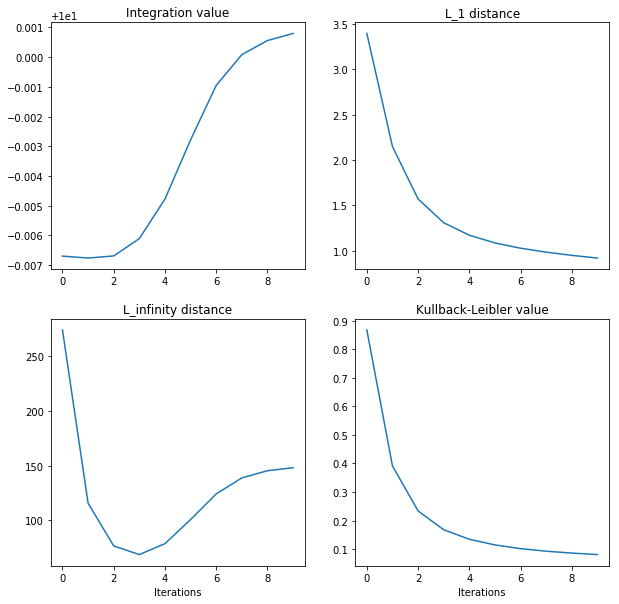

In [10]:
# Plot the error measures.
import matplotlib.pyplot as plt
fig, axs = plt.subplots(2, 2, figsize=(10,10))
axs[0, 0].plot(results["performance"][:, 0])
axs[0, 0].set_title("Integration value")
axs[0, 1].plot(results["performance"][:, 1])
axs[0, 1].set_title("L_1 distance")
axs[1, 0].plot(results["performance"][:, 2])
axs[1, 0].set_title("L_infinity distance")
axs[1, 1].plot(results["performance"][:, 3])
axs[1, 1].set_title("Kullback-Leibler value")

for ax in fig.get_axes()[2:]:
    ax.set(xlabel='Iterations')
plt.show()